### Use the neuralflow kernel
I installed the package with the multi-condition potential and tuning curve optimization in the kernel above

In [1]:
# Import packages 
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec

# my import
#import scipy
import os
from datetime import datetime
import pickle
import random


In [ ]:
# folders for plots and general parameters

plots_dir="./../plot/testing/"

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# general parameters
plot_ext = ".jpg"


In [20]:
# FUNCTION "type_simul": to select the type of simulation
def type_simul(name_simul):
    ''' 
    Function to select the type of simulation and related parameters. 
    All the information are depending on the name of the simulation.
    The lengths to cut can be changed wrt which snippet you want to analyze.
    new_simul: boolean, if True it means that the simulation is in seconds, otherwise in ms.
    '''
    if name_simul == "Jp1_60":
        new_simul = False
        path_data = f'./../data/poster_data/IN_MS_For_Teo_{name_simul}'
        input_data = '/ext_input_coh80_lenS_1000TR0.npy'
        first_prefix_part = 'neurs_raster1_2_In_coh'
        last_prefix_part = '_lenS_1000TR'
        start_to_cut = 7000
        end_to_cut = 5000
        end_trial = 15000
    elif name_simul == "Jp1_65":
        new_simul = False
        path_data = f'./../data/poster_data/IN_MS_For_Teo_{name_simul}'
        input_data = '/ext_input_coh80_lenS_1000TR0.npy'
        first_prefix_part = 'neurs_raster1_2_In_coh'
        last_prefix_part = '_lenS_1000TR'
        start_to_cut = 7000
        end_to_cut = 5000
        end_trial = 15000
    elif name_simul == "Jp1_7":
        new_simul = False
        path_data = f'./../data/poster_data/IN_MS_For_Teo_{name_simul}'
        input_data = '/ext_input_coh80_lenS_1000TR0.npy'
        first_prefix_part = 'neurs_raster1_2_In_coh'
        last_prefix_part = '_lenS_1000TR'
        start_to_cut = 7000
        end_to_cut = 5000
        end_trial = 15000

    return new_simul, path_data, input_data, first_prefix_part, last_prefix_part, end_trial, start_to_cut, end_to_cut
        

In [21]:
# FUNCTION "load_trials": to load the trials

def load_trials(path, prefix_list, input, num_trials, shuffle=False):
    '''
    paht: path to the folder where the trials are stored (relative to the current working directory)
    prefix_list: prefix of the file names (list with the number of trial types)
    input: string with the name of the input file (they are all the same)
    num_trials: number of trials of each type
    shuffle: boolean to shuffle the trials or not
    '''
    trials_per_type = 100 # known value of number of trials per type

    # List all files in the folder
    all_files = os.listdir(path)

    # Filter files that start with the specified string
    filtered_files = [f for f in all_files if any(f.startswith(prefix) for prefix in prefix_list)]

    # Sort the filtered files to ensure they are in order
    filtered_files.sort()
    print(f"filtered_files: {filtered_files}")
    # Load the files and save them in a list
    all_trial_list = [np.load(os.path.join(path, file), allow_pickle=True) for file in filtered_files]
    print(f"all_trial_list: {all_trial_list}")
    data_list = []

    for i in range(len(prefix_list)):
        indices_pre_shuffle = np.arange(num_trials) + i * trials_per_type
        #print(f"indices_pre_shuffle: {indices_pre_shuffle}")
        if shuffle:
            np.random.shuffle(indices_pre_shuffle)

        # Use the list directly here
        data_list.append([all_trial_list[idx] for idx in indices_pre_shuffle])

    # Flatten the list to combine all trials
    flattened_list = [item for sublist in data_list for item in sublist]

    # Load the input data to for the raster plot
    input_data = np.load(path + input, allow_pickle=True)
    num_type_trials = len(prefix_list)

    return flattened_list, input_data, num_type_trials

In [22]:
# FUNCTION "process_trials": to process the trials
def process_trials(change_neurons, neur_to_keep, start_to_cut, end_to_cut, end_trial, data_list):
    ''' 
    change_neurons = how many indices to add to select different neurons
    neur_to_keep: number of neurons to keep
    start_to_cut = from which index to start cutting the data
    end_to_cut = how many indices to cut from the end
    end_trial = end of the trial
    data_list = list with the trials 
    dict_data_dir = directory to save the processed data
    new_simul = if the simulation is new or not, change from ms to s

    OUTPUT: dictionary with the processed data
    dictionary with a key for each trial: dict_data[trial_i] 
    each key: list with the 3 populations of neurons
    each population: array of N neurons
    each neuron: array of the spikes times
    '''

    dict_data = {}
    len_trial = end_trial - (end_to_cut + start_to_cut)
    
    for i, trial in enumerate(data_list):
        pop_1 = np.zeros((neur_to_keep), dtype=object)
        pop_2 = np.zeros((neur_to_keep), dtype=object)
        pop_I = np.zeros((neur_to_keep), dtype=object)
        pops = [pop_1, pop_2, pop_I]
        
        for pop, pop_data in zip(pops, trial.values()): 
            for neur in range(neur_to_keep):
                idx = (pop_data[neur+change_neurons] > start_to_cut) & (pop_data[neur+change_neurons] < end_trial - end_to_cut)
                pop[neur] = pop_data[neur+change_neurons][idx] - start_to_cut
        dict_data[f"trial_{i}"] = pops
    
    return dict_data, len_trial

In [23]:
# FUNCTION "plot_raster_with_input": to plot the raster with input

def plot_raster_with_input(name_simul, change_neurons, neur_to_keep, n_trials, dict_data, trial_to_plot, len_trial, input_data, start_to_cut, end_to_cut, end_trial, plot_data_for_run, plot_ext):

    """
    Plots raster data for neuron populations and input over a specified trial.

    Parameters:
        dict_data (dict): Dictionary containing trial data for each population.
        trial_to_plot (str): Key for the trial to plot (e.g., 'trial_2').
        len_trial (int): Length of the trial in time steps.
        input_data (np.array): Array of input data to plot.
        start_to_cut (int): Start index for data truncation.
        end_to_cut (int): End index for data truncation.
        end_trial (int): End of the trial.
        num_type_trials (int): Number of trial types for saving plot names.
        plots_raw_data (str): Path to save the plot.
        plot_ext (str): Extension format for saved plot (e.g., '.jpg').

    Returns:
        None: Displays and saves the plot.
    """
    
    start_to_cut = int(start_to_cut)
    end_to_cut = int(end_to_cut)
    len_input = end_trial - (end_to_cut + start_to_cut)

    # Create a figure and subplots for each population and input
    fig, axs = plt.subplots(4, 1, figsize=(10, 7))
    fig.suptitle('Raster plot neurons and input')

    # Plot neuron population rasters
    axs[0].eventplot(dict_data[trial_to_plot][0][:])
    axs[0].set_title('Pop 1')
    axs[0].set_xlim([0, len_trial])

    axs[1].eventplot(dict_data[trial_to_plot][1][:])
    axs[1].set_title('Pop 2')
    axs[1].set_xlim([0, len_trial])

    axs[2].eventplot(dict_data[trial_to_plot][2][:])
    axs[2].set_title('Pop I')
    axs[2].set_xlim([0, len_trial])

    # Plot input data
    axs[3].plot(input_data[start_to_cut:start_to_cut+len_input, 0])
    axs[3].set_title('Input')
    axs[3].set_xlim([0, len_input])
    axs[3].set_xlabel("Time (ms)")

    # Adjust subplot spacing and save figure
    plt.tight_layout()

    fig.savefig(plot_data_for_run + f'/{name_simul}_raster_plot_with_input_neurons={neur_to_keep}_change_neurons={change_neurons}_trials={n_trials}{plot_ext}')
    plt.show()


filtered_files: ['neurs_raster1_2_In_coh80_lenS_1000TR0.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR1.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR10.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR11.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR12.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR13.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR14.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR15.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR16.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR17.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR18.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR19.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR2.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR20.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR21.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR22.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR23.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR24.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR25.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR26.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR27.npz', 'neurs_raster1_2_In_

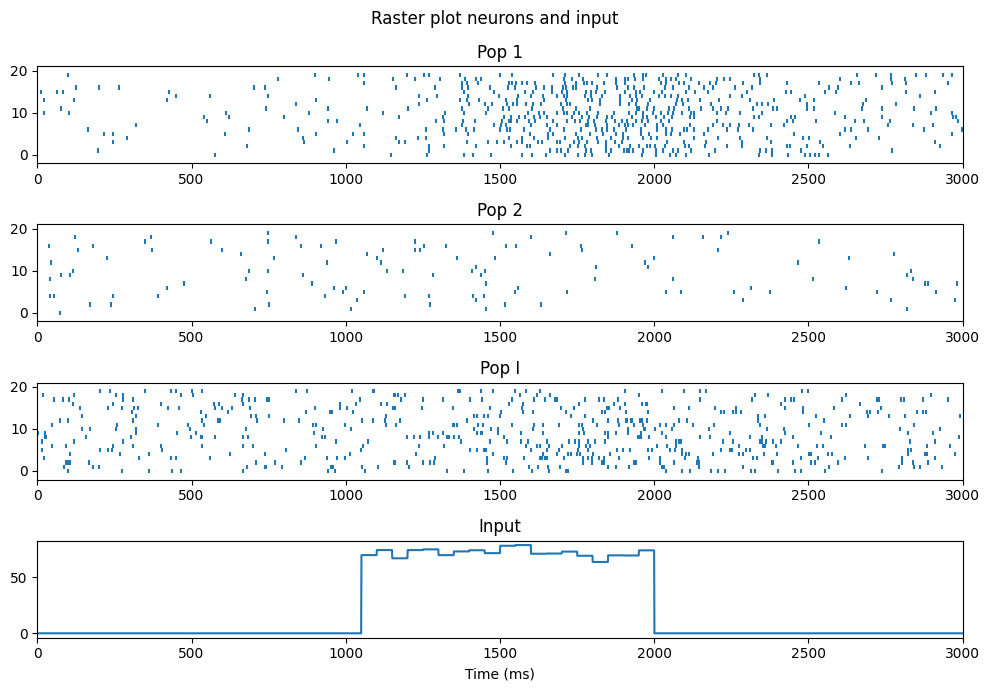

In [25]:
# CELL 1 - to make the raster plot with input

# TODO: make a single cell with everything. Put this outside the loop

# load the data: number of trials and type of trials
name_simul = "Jp1_65" #"Jp1_60", "Jp1_65", "Jp1_7", "Jp1_75", "Jp1_80"
new_simul, path_data, input_data, first_prefix_part, last_prefix_part, end_trial, start_to_cut, end_to_cut = type_simul(name_simul)
n_trials = 10 # number of trials of each type
change_neurons = 0 # when equal 0 means no change. If you want to change all the neurons, change to something > neur_to_keep
neur_to_keep = 20 # number of neurons to keep
coherence_plot = [80]#, -80] # coherence of the trials to plot
prefix_list =[]

# create the folder with the dataset for the inference of the model
plot_data_for_run = plots_dir + f'dataset_{name_simul}_start={start_to_cut}_end={end_trial - end_to_cut}/'
if not os.path.exists(plot_data_for_run):
    os.makedirs(plot_data_for_run)

# loop to create the prefix list to load the trials of the corresponding coherence
for coher in range(len(coherence_plot)):
    prefix_list.append(first_prefix_part + f'{coherence_plot[coher]}' + last_prefix_part)

# load the trials and process them
data_list, input_data, num_type_trials = load_trials(path_data, prefix_list, input_data, n_trials, shuffle=False)
dict_data, len_trial = process_trials(change_neurons, neur_to_keep, start_to_cut, end_to_cut, end_trial, data_list)

# plot the raster with input
trial_to_plot = 'trial_7' 
plot_raster_with_input(
    name_simul = name_simul,
    change_neurons = change_neurons,
    neur_to_keep = neur_to_keep,
    n_trials = n_trials,
    dict_data=dict_data,
    trial_to_plot=trial_to_plot,
    len_trial=len_trial,
    input_data=input_data,
    start_to_cut=start_to_cut,
    end_to_cut=end_to_cut,
    end_trial=end_trial,
    plot_data_for_run=plot_data_for_run,
    plot_ext=plot_ext
)

In [26]:
# FUNCTION "structure_data_for_model": to create the input data for the model

def structure_data_for_model(n_pop, neur_to_keep, end_trials, dict_data, dt):
    '''
    n_trials: number of trials to use per type of trials  ### Delete
    n_pop: number of populations
    neur_to_keep: number of neurons to keep per population
    end_trials: end of the trials
    dict_data: dictionary with the data
    dt: rescaling factor to match the model time step (?still need to underatnd properly why this is needed)
    '''
    # create the object array to store the spike times for each neuron and trial
    spikes = np.empty((neur_to_keep*n_pop, len(dict_data)), dtype = object)

    # loop for each neuron and trial to store the spike times form the dictionary 
    # iteration over trials
    for t,trial in enumerate(list(dict_data.keys())):
        # iteration over the different populations
        for pop in range(n_pop):
            # iteration over the neurons in each population
            for neur in range(neur_to_keep): 
                # assign the spike of the neuron of the population in the trial to the object array       
                spikes[pop*len(dict_data[trial][pop])+neur,t] = dict_data[trial][pop][neur] 
                #print(f"iteration check neurons {dict_data[trial][pop][neur] }")
    print(spikes.shape)
    #print(f"spikes neur 0 trial 0 before rescaling {spikes[0,0]} and spikes neur 0 trial 10 before rescaling {spikes[2,0]}")

    #spikes is a 2D array with the neurons in the rows and the trials in the columns. Each element of the array is an array with the spike times of the neuron in the trial.

    # weird behave, it seems the time rescaling helps to avoid NaNs... 
    spikes = spikes / dt
    end_trials = end_trials / dt
    dict_spikes={"trial_end_time": end_trials ,"spikes": spikes}
    #print(f"spikes neur 0 trial 0 after rescaling {spikes[0,0]} and spikes neur 2 trial 0 before rescaling {spikes[2,0]}")


    # save the data in a pickle file 
    #with open(dict_data_dir + '/dict_for_ISI_multiple_trials.pickle', 'wb') as file:
    #    pickle.dump(dict_spikes, file)

    return dict_spikes

In [27]:
# FUNCTION "firing_model_func": to create the firing model for the neurons
def firing_model_func(neur_to_keep, n_pop, slope, threshold):
    slope = [slope if i < neur_to_keep else -slope for i in range(neur_to_keep * n_pop)]
    threshold = [-threshold if i < neur_to_keep else threshold for i in range(neur_to_keep * n_pop)]
    firing_model = []
    for neur in range(neur_to_keep * n_pop):
        firing_model.append({"model": "rectified_linear", "params": {"r_slope": slope[neur], "x_thresh": threshold[neur]}})
    return firing_model

In [28]:
# FUNCTION "fit_model": to fit the model

def fit_model(data_ISI, firing_model, neur_to_keep, number_of_iterations, peq_model, p0_model, n_pop): 

    ''' 
    !!! possibly the crucial part 
    # Let us reinitialize the model to reset the initial guess paramters (it is useful if you want to execute this cell more than 1 time)
    # em_fitting = neuralflow.EnergyModel(**EnergyModelParams) # after the options part....
    # the tutorial separate the option part from the EnergyModelParams and wrote the above. Probably in there lays the reason why rerunning gives different results
    '''
    # explicitly calling the energy model parameters for the plot saving 
    # method to solve the partial differential equation
    method = "SEM"
    # prior for the equilibrium distribution, thus potential 
    ## peq_model = "uniform"  #cos_square, cos_fourth_power, single_well, double_well, uniform, mixture, custom, jump_spline2, linear_pot
    # prior for the initial distribution of the latent state
    ## p0_model = "uniform"
    D0 = 0.56 # initial guess for the diffusion coefficient
    # condition on the boundary, if absorbing only trajecotries which end at the end of the trial are considered. When reflecting the trajectories are reflected at the boundary
    boundary_mode = "absorbing" # reflecting, absorbing
    # number of retained time evolution eigenvectors 
    Nv = 111

    EnergyModelParams={'pde_solve_param':{'method':{'name': method, 'gridsize': {'Np': 8, 'Ne': 16}}},  
                   'Nv': Nv, ## rememeber 111  
                   'peq_model':{"model": peq_model, "params": {}},
                   'D0': D0, ### change and pass it as a parameter
                   'p0_model':{"model": p0_model, "params": {}},
                    'boundary_mode':boundary_mode, #reflecting
                    'num_neuron':neur_to_keep*n_pop,
                    'firing_model':firing_model,
                   'verbose':True
                   }

    # Define optimization parameters: pass the data, define number of iterations, what to infer and the correspondent learning rates
    learn_rate_phi = 0.01 ## original 0.0012
    learn_rate_p0 = 0.025
    learn_rate_D = 0.00025
    #number_of_iterations = 100

    # Define optimization options
    options={}
    options['data']={'dataTR':data_ISI} # here we pass the data
    #options['optimization']={'gamma':{'F':learning_rate},'max_iteration':number_of_iterations}
    options['inference']={'metadataTR':{'last_event_is_spike':False,'absorption_event':True}}
    # below the value in the dictionary of gamma refers to the learning rate for each of the parameters
    options['optimization']={'gamma':{"F": learn_rate_phi, "F0": learn_rate_p0, "D": learn_rate_D},'max_iteration':number_of_iterations,'loglik_tol':0,'etaf':0} # etaf is the regularization strength for the potential function (default is 0)
    # from tutorial parameters "F": 0.0012, "F0": 0.025, "D": 0.00025 

    em_fitting = neuralflow.EnergyModel(**EnergyModelParams)

    em_fitting.fit('GD',options)

    return em_fitting

In [29]:
# FUNCTION "plot_main_results" to plot the main results

def plot_main_results(name_simul, plot_run, em_fitting, change_neuron, neur_to_keep, n_trials, number_of_iterations, formatted_now):
    ''' 
    '''
    
    number_of_displayed_iterations = 10
    display_iteration = np.linspace(0,number_of_iterations,number_of_displayed_iterations).astype('int')

    # Create a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, number_of_displayed_iterations+1))

    # create a coherence level folder ->  lower_coherence
    fitted_peqs = em_fitting.iterations_GD_.keys()
    logliks = em_fitting.iterations_GD_['logliks']
    fitted_peqs = em_fitting.iterations_GD_['peqs']
    prob_p0 = em_fitting.iterations_GD_['p0s']
    diffusion_D = em_fitting.iterations_GD_['Ds']

    print(f"len fitted_peqs {len(fitted_peqs)}")
    min_potential = np.min(fitted_peqs[:-1])
    print(f"min potential {min_potential}")
    # plot the fitted parameters
    fig=plt.figure(figsize=(20,12))
    fig.suptitle(f'{name_simul}_neurons={neur_to_keep*2}, change_neuron_index={change_neuron}, trials={n_trials*2}, iter={number_of_iterations}', fontsize=20)
    gs=gridspec.GridSpec(2,2,wspace=0.5,hspace=0.5)

    ax = plt.subplot(gs[0])
    ax.set_title(r'Cost function, $-\log\mathscr{L}$', fontsize=14)
    plt.xlabel('Iteration number', fontsize=14)
    plt.ylabel(r'$-\log\mathscr{L}$', fontsize=14)
    ax.plot(np.array(range(number_of_iterations+1)),logliks)

    ax = plt.subplot(gs[1])
    ax.set_title(r'Fitted potentials', fontsize=14)
    plt.xlabel(r'Latent state, $x$', fontsize=14)
    plt.ylabel(r'$Potential, \Phi(x)$', fontsize=14)
    for i,it in enumerate(display_iteration):
        plt.plot(em_fitting.x_d_,-np.log(fitted_peqs[:,it]),label=f'Iteration {it}', c=colors[i])
    plt.legend()

    ax = plt.subplot(gs[2])
    ax.set_title(r'Fitted p0', fontsize=14)
    plt.xlabel(r'Latent state, $x$', fontsize=14)
    plt.ylabel(r'$p0(x)$', fontsize=14)
    for i,it in enumerate(display_iteration):
        plt.plot(em_fitting.x_d_,prob_p0[:,it],label=f'Iteration {it}', c=colors[i])
    plt.legend()

    ax = plt.subplot(gs[3])
    ax.set_title(r'Fitted D', fontsize=14)
    plt.xlabel('Iteration number', fontsize=14)
    plt.ylabel(r'$D(x)$', fontsize=14)
    plt.plot(np.array(range(number_of_iterations+1)),diffusion_D)

    plt.show()
    fig.savefig(plot_run + f'/{name_simul}_fitted_params_change_neur={change_neuron}_N={neur_to_keep*2}_number_of_iterations={number_of_iterations}_trials={n_trials*2}_{formatted_now}{plot_ext}')


In [ ]:
## test for ISI

name_simul = "Jp1_65" # "Jp1_60", "Jp1_65", "Jp1_7", "Jp1_75", "Jp1_80"
new_simul, path_data, input_data, first_prefix_part, last_prefix_part, end_trial, start_to_cut, end_to_cut = type_simul(name_simul)
n_trials = 20 # number of trials of each type
neur_to_keep = 1 # number of neurons to keep
n_pop = 1 # number of populations
dt = 10000 # rescaling factor to match the model time step (?still need to underatnd properly why this is needed)
coherence_plot = [80] # coherence of the trials to plot
prefix_list =[]
# loop to create the prefix list to load the trials of the corresponding coherence
for coher in range(len(coherence_plot)):
    prefix_list.append(first_prefix_part + f'{coherence_plot[coher]}' + last_prefix_part)

# load the trials
data_list, input_data, num_type_trials = load_trials(path_data, prefix_list, input_data, n_trials, shuffle=False)
print(f'Loaded {len(data_list)} files.')

change_neurons = 0 # when equal 0 means no change. If you want to change all the neurons, change to something > neur_to_keep
neur_to_keep = 1 # number of neurons to keep
dict_data, len_trial = process_trials(change_neurons, neur_to_keep, start_to_cut, end_to_cut, end_trial, data_list, new_simul=new_simul)
end_trials = np.full(len(dict_data), len_trial/dt) # the end time of each trial, this work only with trials ending at the same time
time_epoch = [(0,trial_end) for trial_end in end_trials]
print(f"time epoch is {time_epoch}")
dict_spikes = structure_data_for_model(n_pop, neur_to_keep, end_trials, dict_data, dt)
print(f"testing the structure of the data {dict_spikes['spikes'][0,1]}")
slope = 50
threshold = 1
firing_model = firing_model_func(neur_to_keep, n_pop, slope, threshold)

# testing the problem about the final value in the ISI too high 
print(dict_spikes['spikes'][0,0])

# new approach to create the model 
datasample1 = neuralflow.SpikeData(data = dict_spikes['spikes'], dformat = 'spiketimes', time_epoch = time_epoch)
print(datasample1.data.shape)
datasample1.change_format('ISIs')
print(datasample1.data[0,0])
#datasample1 = np.delete(datasample1)
# try to fit the model with the new architecture

grid = neuralflow.GLLgrid(Np = 8, Ne = 16)

# Initial guess
init_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "cos_square", "params": {}},
    D = 1,
    fr_model = [{"model": "linear", "params": {"slope": 1, "bias": 100}}] * neur_to_keep * n_pop,
    params_size={'peq': 1, 'D': 1, 'fr': 1, 'p0': 1}, # Here is very important, decide the number of peq corresponding to the len of the list of the ISI dataset
    grid = grid
)

optimizer = 'ADAM'

# In the paper we set max_epoch = 5000, mini_batch_number = 20, and did 30 line searches logarithmically scattered across 5000 epochs.
# Here we change these parameters to reduce optimization time
opt_params = {'max_epochs': 50, 'mini_batch_number': 20, 'params_to_opt': ['F', 'F0', 'D', 'Fr', 'C'], 'learning_rate': {'alpha': 0.05}}
ls_options = {'C_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 2}, 'D_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 25}}
boundary_mode = 'absorbing'

# Train on datasample 1
#dataTR = [v for v in datasample1.values()]
print(f"datasample1 {datasample1}")
optimization1 = neuralflow.optimization.Optimization(
                    datasample1,
                    init_model,
                    optimizer,
                    opt_params,
                    ls_options,
                    boundary_mode=boundary_mode
                    #device='CPU'
                )

# run optimization
print('Running optimization on datasample 1')
optimization1.run_optimization()


loop for which neuron =0
(10, 100)
spikes[1,1][:10] are [0.00268 0.0106  0.05974 0.06259 0.08038 0.11846 0.1227  0.16163 0.20392
 0.21824]
ISI data shape (100, 2), an example is [0.00629 0.00822 0.00052 0.00093 0.00301 0.01518 0.01004 0.01372 0.00371
 0.00095]


100%|██████████| 100/100 [13:22<00:00,  8.02s/it]


len fitted_peqs 113
min potential 0.03136142308320819


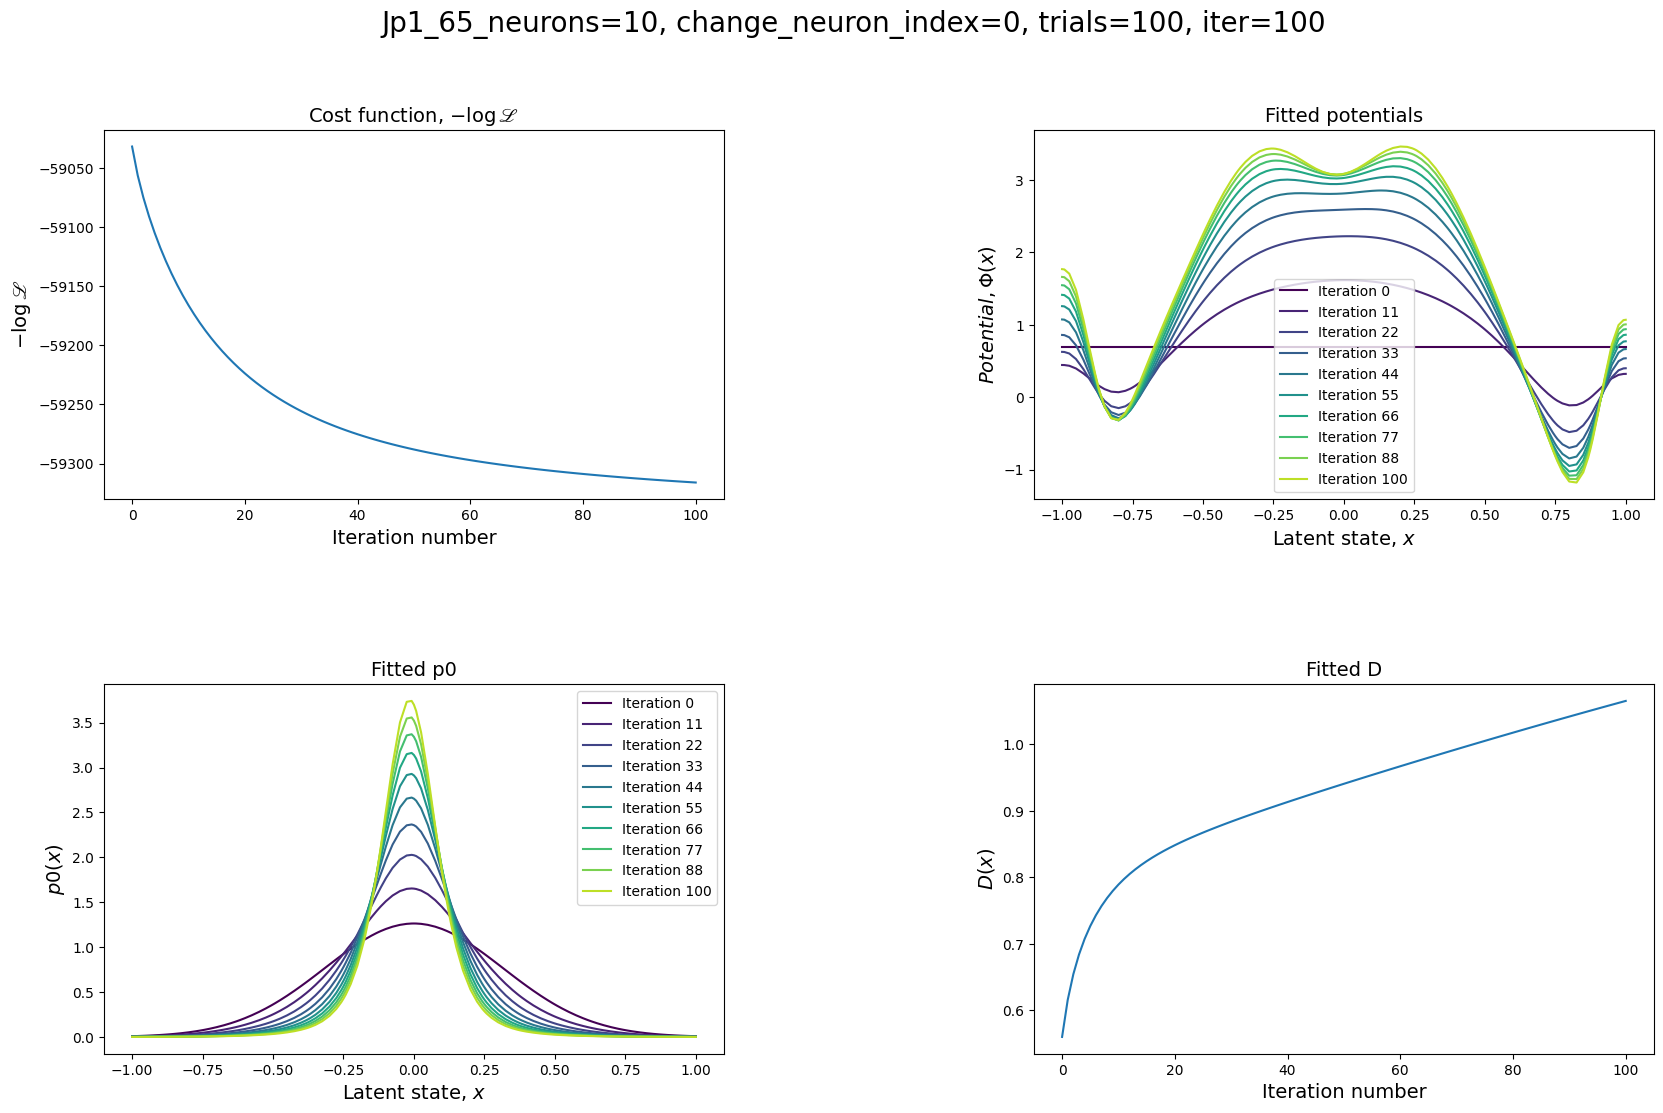

dict_em_fitting[f"iter_change_neur0"] is dict_keys(['logliks', 'peqs', 'p0s', 'Ds'])
loop for number of neuron=0 done
loop for which neuron =10
(10, 100)
spikes[1,1][:10] are [0.02919 0.12735 0.13264 0.15358 0.24862 0.26017]
ISI data shape (100, 2), an example is [0.00241 0.00108 0.00734 0.00105 0.01558 0.009   0.00621 0.00597 0.007
 0.00201]


100%|██████████| 100/100 [11:18<00:00,  6.78s/it]


len fitted_peqs 113
min potential 0.04181834533247705


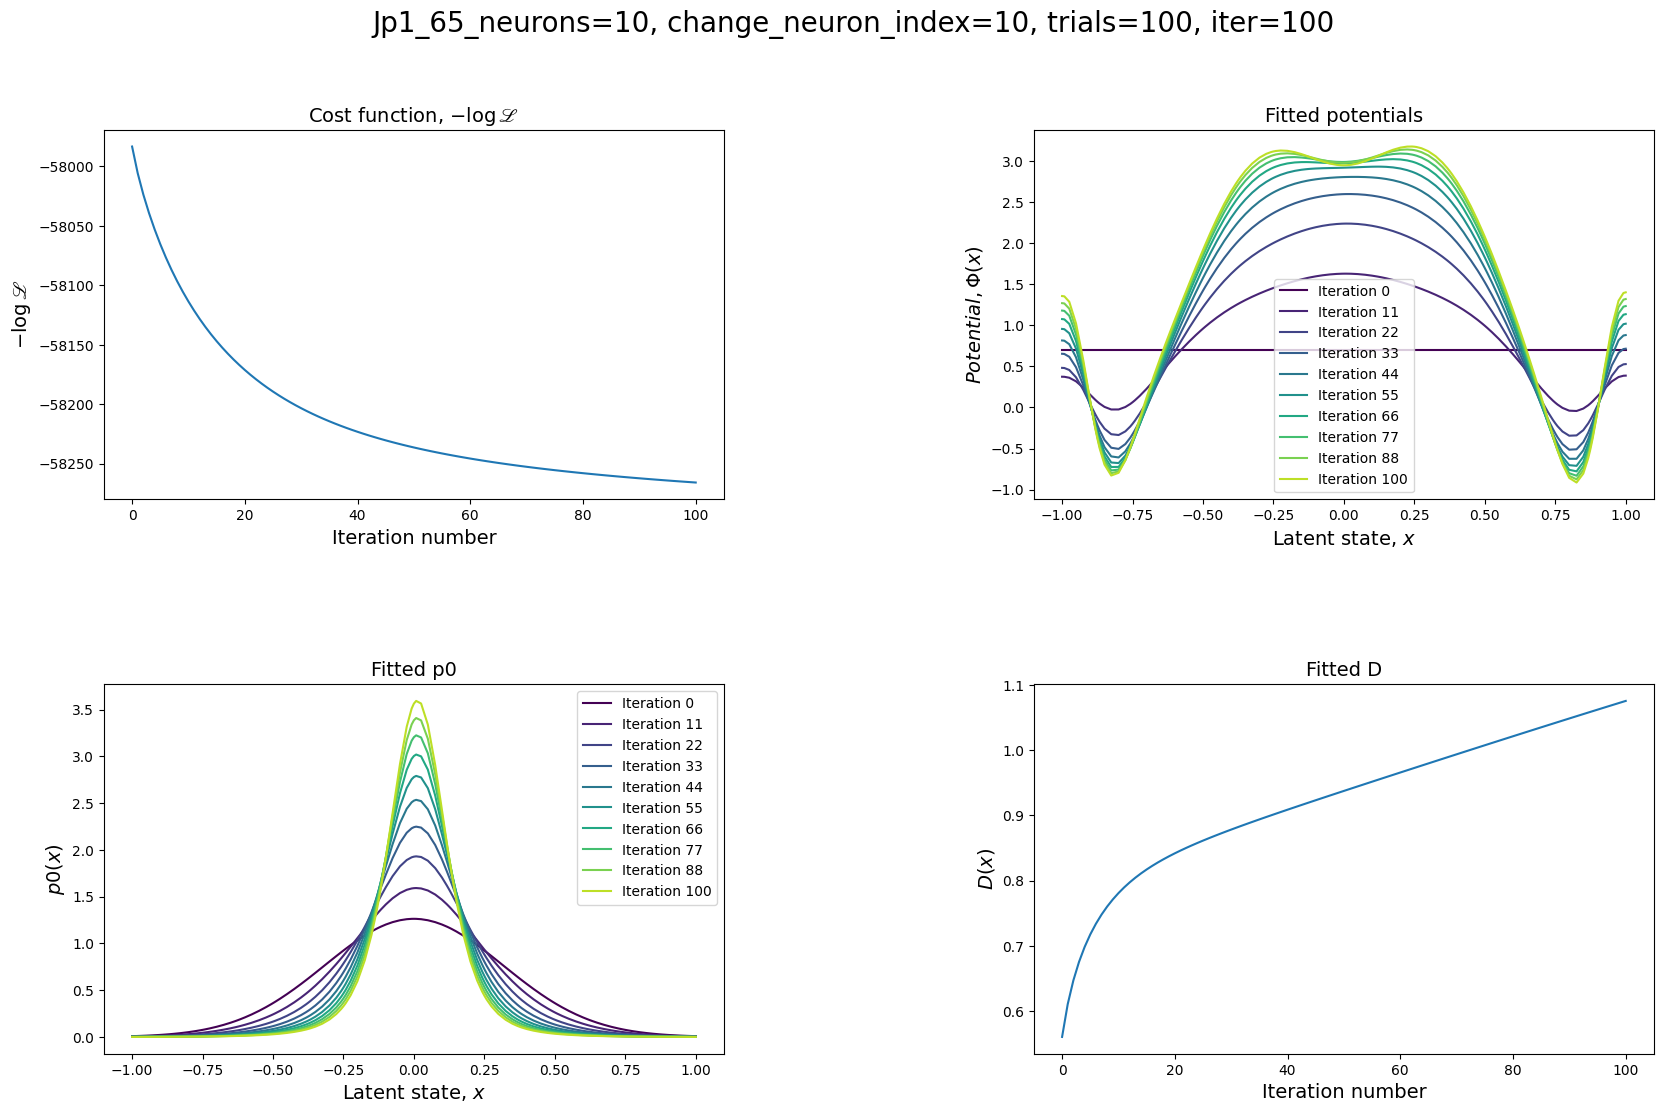

dict_em_fitting[f"iter_change_neur10"] is dict_keys(['logliks', 'peqs', 'p0s', 'Ds'])
loop for number of neuron=10 done
loop for which neuron =20
(10, 100)
spikes[1,1][:10] are [0.00754 0.01151 0.05715 0.0701  0.08991 0.11066 0.13565 0.1883  0.25019
 0.26914]
ISI data shape (100, 2), an example is [0.00286 0.00067 0.00088 0.00936 0.00497 0.00556 0.00021 0.00246 0.00794
 0.0016 ]


100%|██████████| 100/100 [13:24<00:00,  8.04s/it]


len fitted_peqs 113
min potential 0.057812319020767076


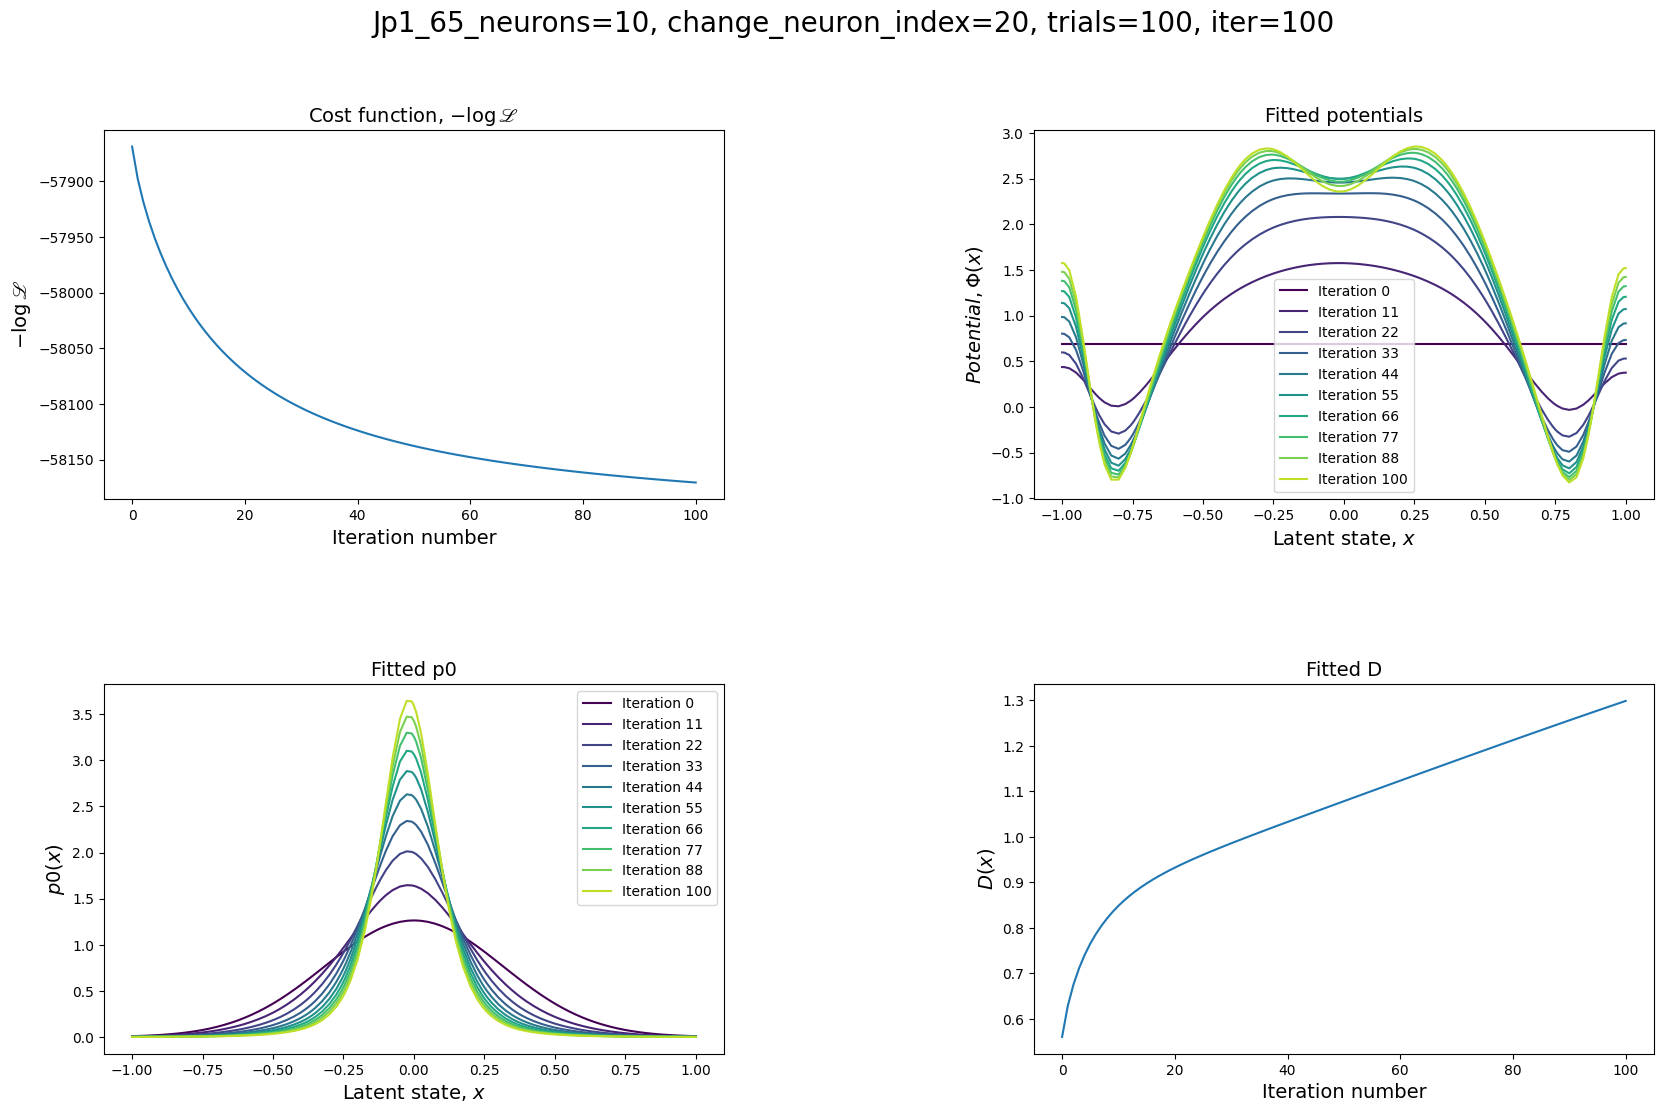

dict_em_fitting[f"iter_change_neur20"] is dict_keys(['logliks', 'peqs', 'p0s', 'Ds'])
loop for number of neuron=20 done
loop for which neuron =30
(10, 100)
spikes[1,1][:10] are [0.01431 0.04637 0.1027  0.10711 0.11529 0.11933 0.13988 0.19166]
ISI data shape (100, 2), an example is [0.00315 0.00228 0.00351 0.00294 0.00065 0.00812 0.00177 0.00778 0.00477
 0.00281]


100%|██████████| 100/100 [12:45<00:00,  7.65s/it]


len fitted_peqs 113
min potential 0.03433648809967041


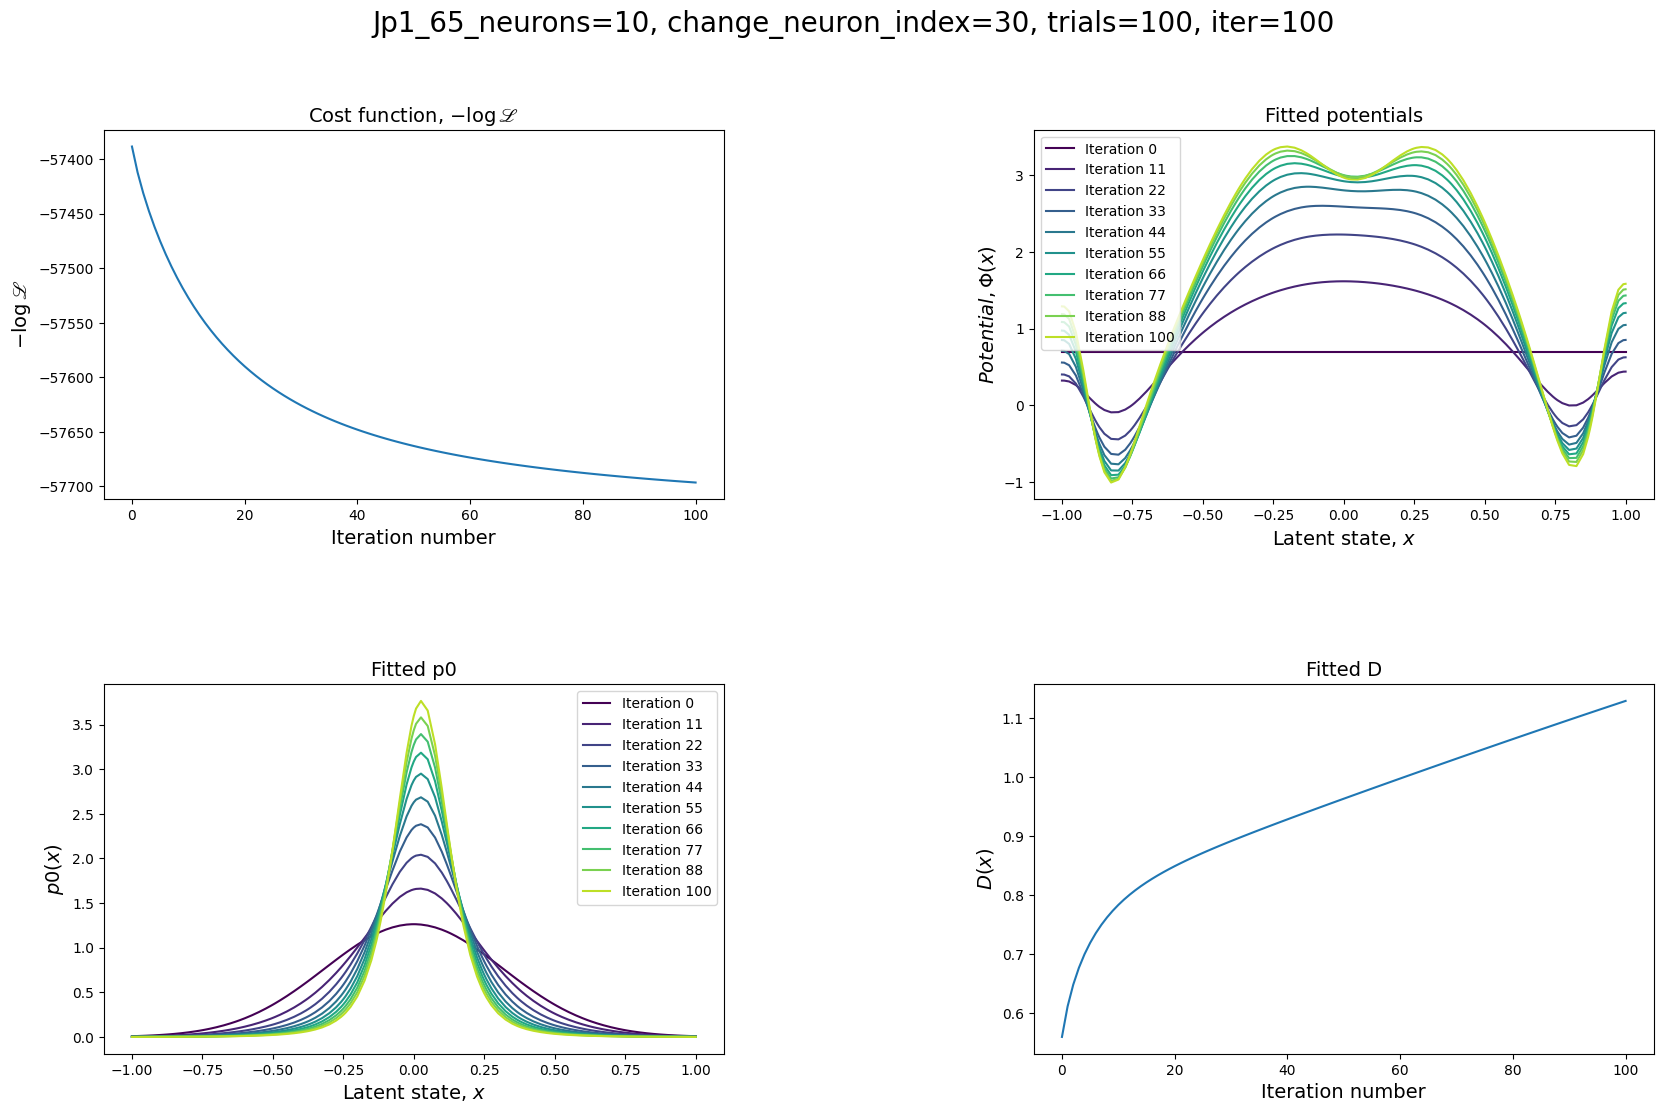

dict_em_fitting[f"iter_change_neur30"] is dict_keys(['logliks', 'peqs', 'p0s', 'Ds'])
loop for number of neuron=30 done
loop for which neuron =40
(10, 100)
spikes[1,1][:10] are [0.00041 0.00622 0.0082  0.03489 0.05246 0.0572  0.06414 0.06942 0.10728
 0.20364]
ISI data shape (100, 2), an example is [0.00439 0.00109 0.00647 0.00782 0.00742 0.00305 0.00423 0.00177 0.00229
 0.00091]


100%|██████████| 100/100 [11:55<00:00,  7.16s/it]


len fitted_peqs 113
min potential 0.04582974102621144


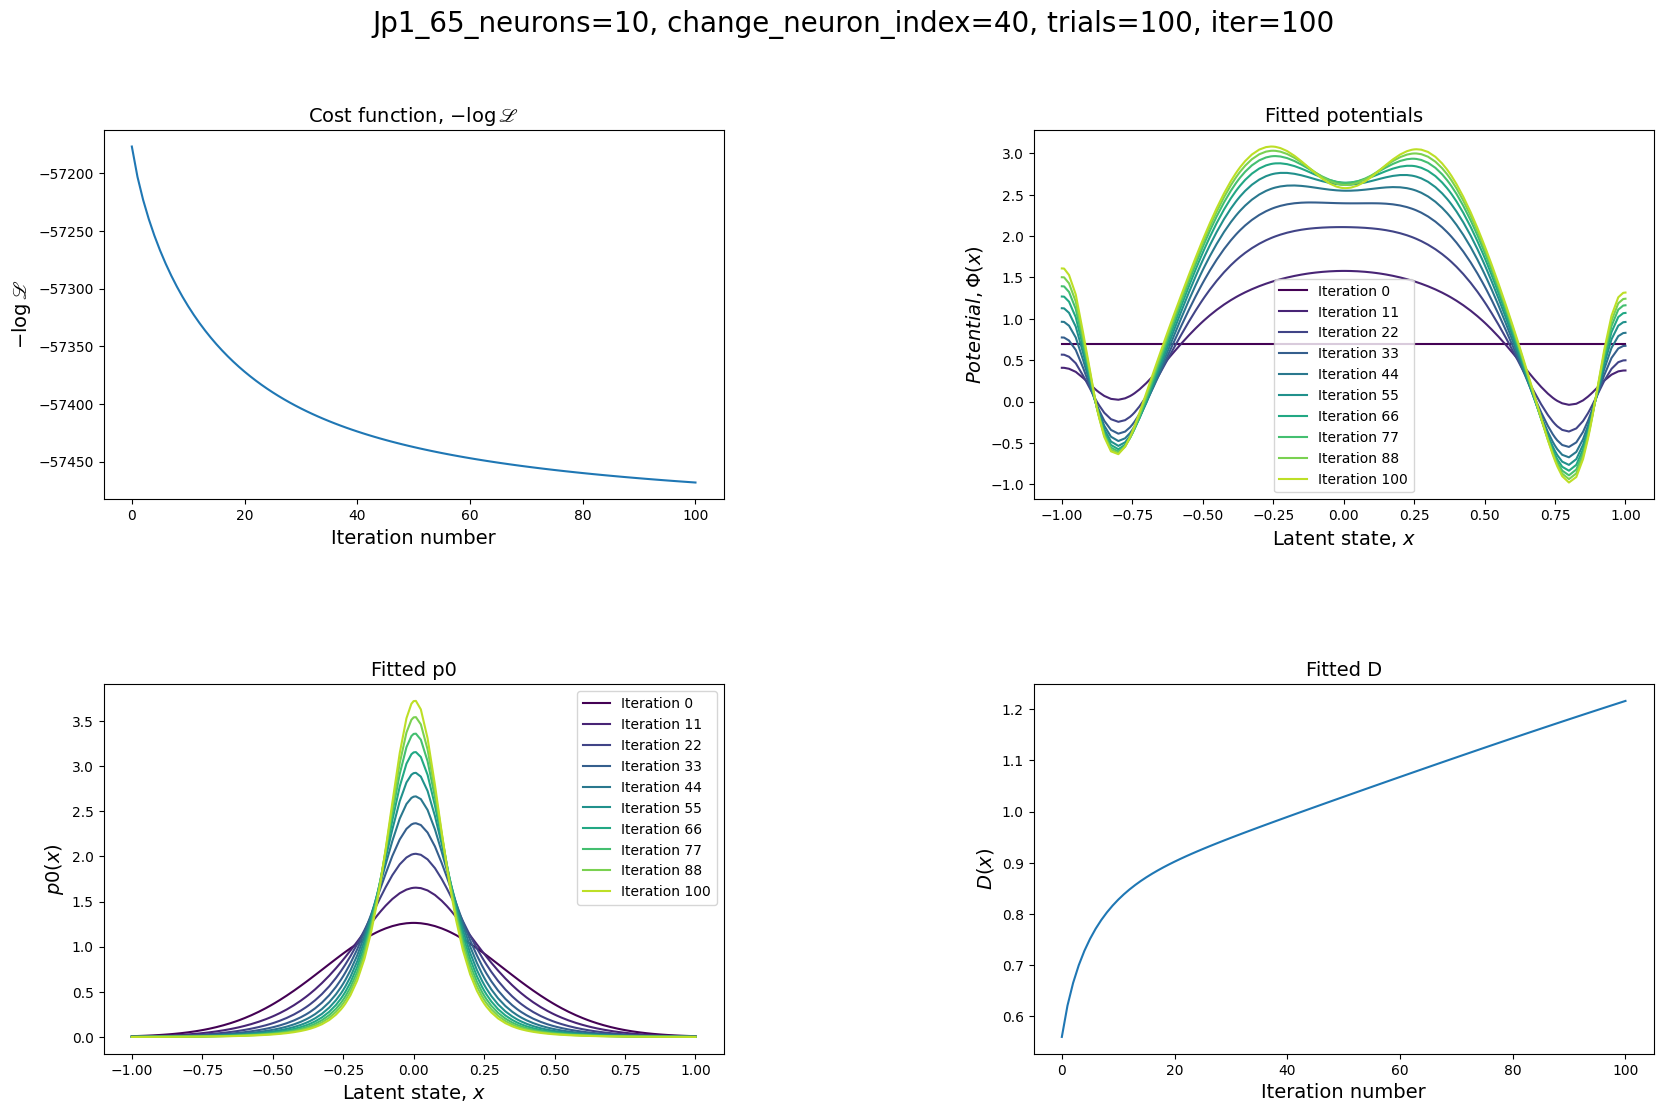

dict_em_fitting[f"iter_change_neur40"] is dict_keys(['logliks', 'peqs', 'p0s', 'Ds'])
loop for number of neuron=40 done
loop for which neuron =50
(10, 100)
spikes[1,1][:10] are [0.03526 0.13267 0.17118 0.20775 0.2217  0.29903]
ISI data shape (100, 2), an example is [0.00125 0.00048 0.00423 0.00532 0.00715 0.00918 0.00225 0.0076  0.00303
 0.0038 ]


100%|██████████| 100/100 [12:30<00:00,  7.51s/it]


len fitted_peqs 113
min potential 0.03028913817768587


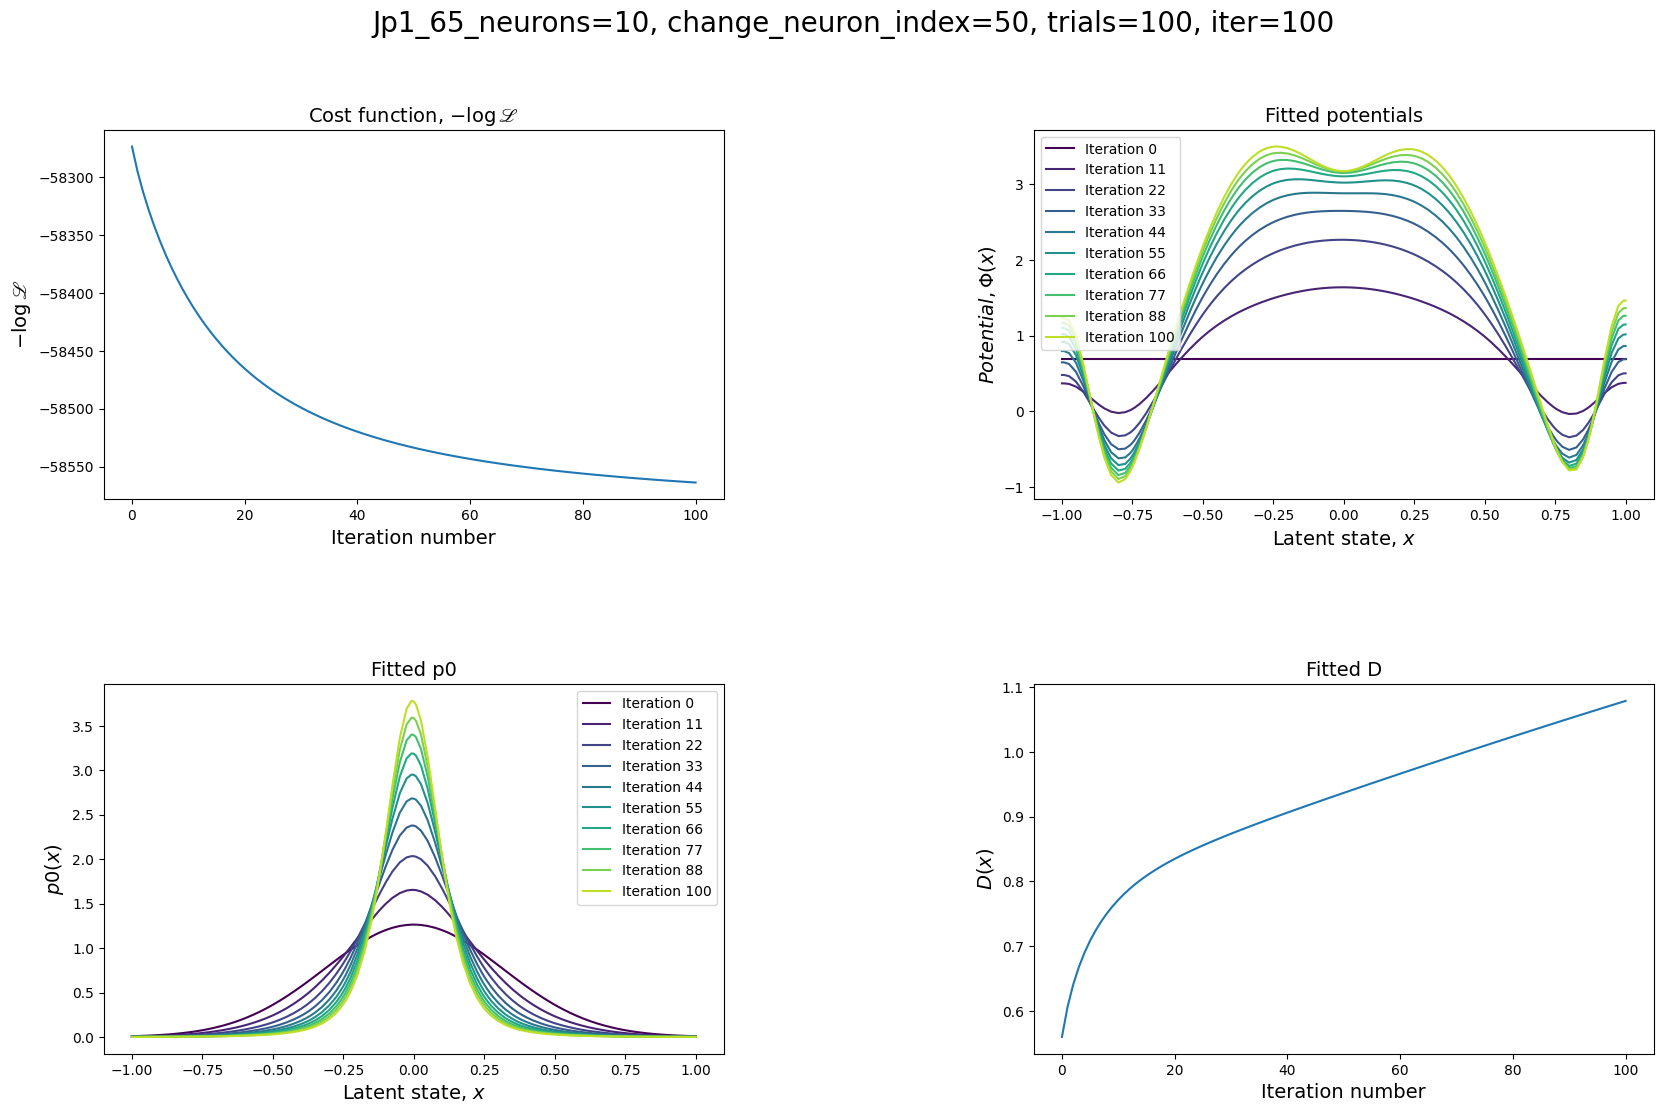

dict_em_fitting[f"iter_change_neur50"] is dict_keys(['logliks', 'peqs', 'p0s', 'Ds'])
loop for number of neuron=50 done


In [ ]:
### CELL 2: Loop to fit the model for different neurons 

# Get the current date and time and format it
now = datetime.now()
formatted_now = now.strftime("%Y%m%d_%H%M%S")

# PARAMETERS DECLARATION
# pre run parameters
num_type_trials = len(coherence_plot)

# modification of the parameters for the inference
neur_to_keep = 5 # number of neurons to keep  #neur_to_keep_list = [2, 4, 6, 8, 10] # list of number of neurons to keep
change_neurons_list = [neur_to_keep*0,neur_to_keep*2,neur_to_keep*4, neur_to_keep*6, neur_to_keep*8, neur_to_keep*10] # when equal 0 means no change. If you want to change all the neurons, change to something > neur_to_keep
number_of_iterations = 300
n_trials = 50

# fixed paramters for the inference
n_pop = 2 # number of populations (the first 2 excitatory populations, no inhibitory population)
peq_model = "uniform" #cos_square, cos_fourth_power, single_well, double_well, uniform, mixture, custom, jump_spline2, linear_pot
p0_model = "single_well" # prior for the initial distribution of the latent state
D0 = 0.56
boundary_mode = "absorbing" # reflecting, absorbing 
method = "SEM"
Nv = 111
learn_rate_phi = 0.01 ## original 0.0012
learn_rate_p0 = 0.025
learn_rate_D = 0.00025
slope = 50
threshold = 1

#dictionary to store the results
names_em_fitting = ["logliks", "peqs", "p0s", "Ds"]
dict_em_fitting = {}

# loading the files TEST


# create the folder for this inference run
plot_run = plot_data_for_run + f'{name_simul}_loop_who_neurons_fitted_params_N={neur_to_keep*num_type_trials}_trials={n_trials*num_type_trials}_iter{number_of_iterations}'
if not os.path.exists(plot_run):
    os.makedirs(plot_run)


# loop over the neurons to use (the index is added to the original neuron index)
for who in change_neurons_list:
    new_simul, path_data, input_data, first_prefix_part, last_prefix_part, end_trial, start_to_cut, end_to_cut = type_simul(name_simul)
    data_list, input_data, num_type_trials = load_trials(path_data, prefix_list, input_data, n_trials, shuffle=False)
    #print(f'Loaded {len(data_list)} files.')
    print(f"loop for which neuron ={who}")
    # create a dictionary with the data organized per trials and neurons
    dict_data, len_trial = process_trials(who, neur_to_keep, start_to_cut, end_to_cut, end_trial, data_list, new_simul=new_simul)
    # convert in the format accepted by the model to the final conversion in the ISI format
    end_trials = np.full(len(dict_data), len_trial) # the end time of each trial, this work only with trials ending at the same time
    dict_spikes = structure_data_for_model(n_pop, neur_to_keep, end_trials, dict_data, 10000)
    # make explicit the variables for the ISI conversion
    trial_ends = dict_spikes["trial_end_time"]
    spike_times = dict_spikes["spikes"]
    print(f"spikes[1,1][:10] are {spike_times[1,1][:10]}")
    # Initialize an instance of the EnergyModel class
    em = neuralflow.EnergyModel()
    # Create the time_epoch list
    time_epoch = [(0,trial_end) for trial_end in trial_ends]
    # Convert the data into the ISI format
    data_ISI=em.transform_spikes_to_isi(spike_times, time_epoch)
    print(f"ISI data shape {data_ISI.shape}, an example is {data_ISI[0,0][:10]}")
    # create the firing model
    firing_model = firing_model_func(neur_to_keep, n_pop, slope, threshold)

    # fit the model
    em_fitting = fit_model(data_ISI, firing_model, neur_to_keep, number_of_iterations, peq_model, p0_model, n_pop) # this function re-initialize the model every time so that the results are the same
    
    # plot the results
    plot_main_results(name_simul, plot_run, em_fitting, who, neur_to_keep, n_trials, number_of_iterations, formatted_now)
  
    # save the results for the final plot for each iteration 
    dict_em_fitting[f"iter_change_neur{who}"] = {}
    for res in range(len(names_em_fitting)):
        dict_em_fitting[f"iter_change_neur{who}"][names_em_fitting[res]] = em_fitting.iterations_GD_[names_em_fitting[res]]
    print(f'dict_em_fitting[f"iter_change_neur{who}"] is {dict_em_fitting[f"iter_change_neur{who}"].keys()}')

    print(f'loop for number of neuron={who} done')

# save the results for the final plot
with open(plot_data_for_run + f'dict_em_fitting_values_{name_simul}_N={neur_to_keep}_change_neur={change_neurons_list}_trials={n_trials*num_type_trials}_iter={number_of_iterations}_{formatted_now}.pkl', 'wb') as file:
    pickle.dump(dict_em_fitting, file)


In [ ]:
# FUNCTION to plot the tuning curves 

def tuning_curves_plot(neur_to_keep, em_fitting, firing_model):
    '''
    
    '''
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"Firing rate for each neuron, model is {firing_model[0]['model']}")#_with_{firing_model[0]['params']}")
    for neur in range(neur_to_keep*2):
        plt.plot(em_fitting.x_d_, em_fitting.fr_[:,neur], label=f"Params = {firing_model[neur]['params']}")
    plt.legend()
    plt.tight_layout()
    fig.savefig(plots_raw_data + f"/firing_rate_f_model={firing_model[0]['model']}_slope={firing_params0[0]}_thresh={firing_params1[0]}_start={start_to_cut}_end={start_to_cut}_Nv={Nv}_learnPhi={learn_rate_phi}{plot_ext}")
    plt.show()

(113, 4)


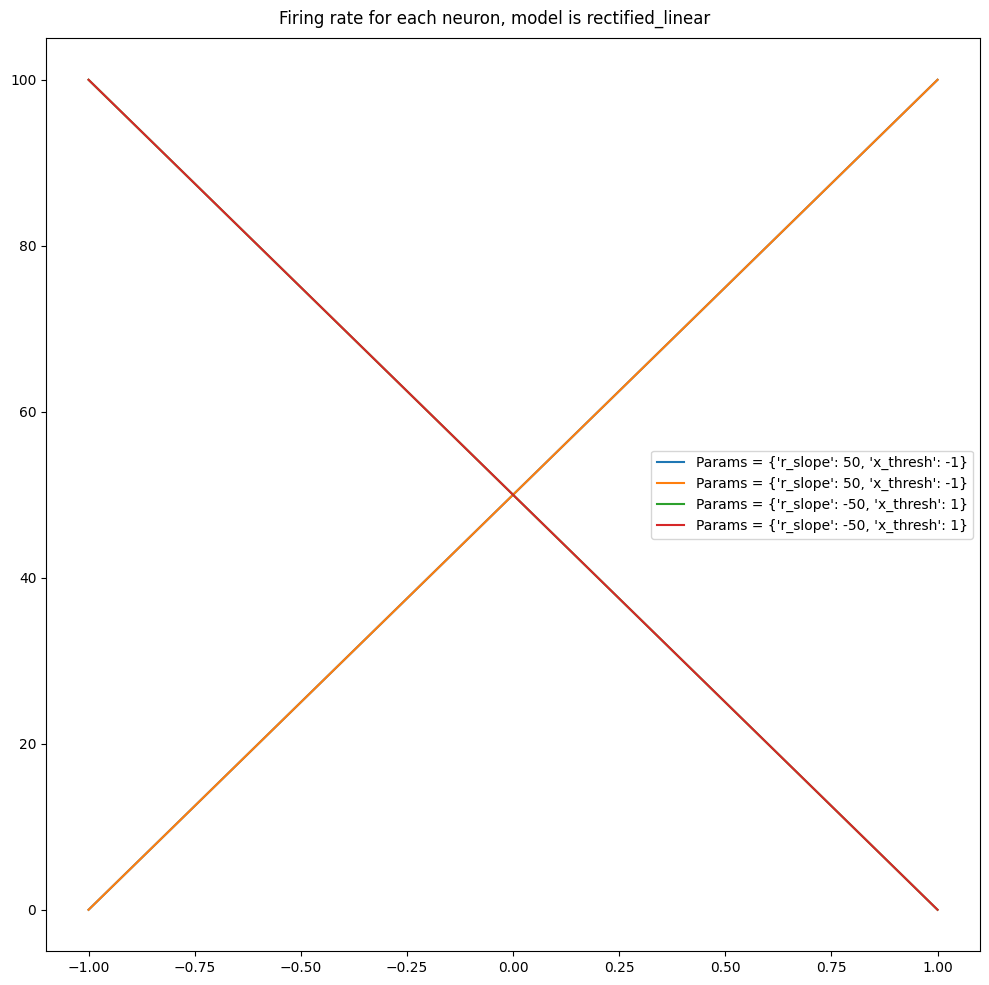

In [25]:
# plot tuning curves

print(em_fitting.fr_.shape)
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Firing rate for each neuron, model is {firing_model[0]['model']}")#_with_{firing_model[0]['params']}")
for neur in range(neur_to_keep*2):
    plt.plot(em_fitting.x_d_, em_fitting.fr_[:,neur], label=f"Params = {firing_model[neur]['params']}")
plt.legend()
plt.tight_layout()
#fig.savefig(plots_raw_data + f"/firing_rate_f_model={firing_model[0]['model']}_slope={firing_params0[0]}_thresh={firing_params1[0]}_start={start_to_cut}_end={start_to_cut}_Nv={Nv}_learnPhi={learn_rate_phi}{plot_ext}")
plt.show()

In [ ]:
# todo examples 
# // TODO: something todo

# // FIXME: a fix is needed

# // BUG: a bug is found